# Importing Modules 

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from math import floor
import cv2
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
if os.path.exists("./tensor_y.npy"):
    os.remove("./tensor_y.npy")
if os.path.exists("./tensor_x.npy"):
    os.remove("./tensor_x.npy")
if os.path.exists("./val_tensor_x.npy"):
    os.remove("./val_tensor_x.npy")
if os.path.exists("./val_tensor_y.npy"):
    os.remove("./val_tensor_y.npy")

# HyperParameters definition

In [3]:
epochs = 100
batch_size = 16
lr = 1e-3

alpha = 0.1

resize_height = 256
resize_width = 256

ratio = 4
train_val_split_perc = 0.9
val_test_split_perc = 0.5

# Converting dataset to jpeg images

In [4]:
!mkdir "/kaggle/working/train/"
!mkdir "/kaggle/working/val/"

In [5]:
import cv2
from tqdm import tqdm
import os

train_dir = "/kaggle/working/train/" 
val_dir = "/kaggle/working/val/"

for img in tqdm(os.listdir("/kaggle/input/div2k-dataset/div2k_train_hr/DIV2K_train_HR/")):
    img_array = cv2.imread("/kaggle/input/div2k-dataset/div2k_train_hr/DIV2K_train_HR/" + img)
    cv2.imwrite(train_dir + img.split(".")[0]+".jpeg", img_array)
for img in tqdm(os.listdir("/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/")):
    img_array = cv2.imread("/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR/" + img)
    cv2.imwrite(val_dir + img.split(".")[0]+".jpeg", img_array)

100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


In [6]:
# Converted dataset images 
import glob
glob.glob('/kaggle/working/train/*')[:5]

['/kaggle/working/train/0751.jpeg',
 '/kaggle/working/train/0175.jpeg',
 '/kaggle/working/train/0145.jpeg',
 '/kaggle/working/train/0017.jpeg',
 '/kaggle/working/train/0523.jpeg']

# Dataset Classes definition

In [7]:
class Generator(keras.utils.Sequence):
    def __init__(self, x: list, y: list):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        return x, y
    
    def __call__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)
            
            if i == self.__len__()-1:
                self.on_epoch_end()

# Dataset Preprocessing

In [8]:
def preprocessing(path, ratio, resize_height, resize_width):
    y = tf.keras.utils.load_img(path)
    y = tf.keras.utils.img_to_array(y)
    y = tf.image.resize(y,
                        [resize_height, resize_width],
                        'bicubic',
                        antialias=True,
                        )
    height, width, _ = y.shape
    x = tf.image.resize(y,
                        [height // ratio, width // ratio],
                        'bicubic',
                        antialias=True,
                        )
    x = x / 255.0
    y = y / 255.0
    return x, y

In [9]:
# Gather up all the data
img_paths = []
val_img_paths = []
for dirname, _, filenames in os.walk(train_dir):
    for filename in filenames:
        img_paths.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk(val_dir):
    for filename in filenames:
        img_paths.append(os.path.join(dirname, filename))
        
print('Dataset dimension: ', len(img_paths))

val_img_paths = img_paths[floor(len(img_paths) * train_val_split_perc):]
img_paths = img_paths[:floor(len(img_paths) * train_val_split_perc)]
print('Training: ', len(img_paths))

Dataset dimension:  900
Training:  810


In [10]:
if not (os.path.exists('./tensor_x.npy')) or not (os.path.exists('./tensor_y.npy')):

    img_lr = []
    img_hr = []

    for i in tqdm(range(len(img_paths))):
        x, y = preprocessing(img_paths[i], ratio, resize_height, resize_width)
        img_lr.append(x)
        img_hr.append(y)
    
    tensor_x = tf.convert_to_tensor(img_lr).numpy()
    tensor_y = tf.convert_to_tensor(img_hr).numpy()
    tensor_x.shape

    np.save('./tensor_x.npy', tensor_x)
    np.save('./tensor_y.npy', tensor_y)
    img_lr = tensor_x
    img_hr = tensor_y
else:
    img_lr = np.load('./tensor_x.npy')
    img_hr = np.load('./tensor_y.npy')

    

100%|██████████| 810/810 [01:49<00:00,  7.42it/s]


In [11]:
if not (os.path.exists('./val_tensor_x.npy')) or not (os.path.exists('./val_tensor_y.npy')):

    val_img_lr = []
    val_img_hr = []

    for i in tqdm(range(len(val_img_paths))):
        x, y = preprocessing(val_img_paths[i], ratio, resize_height * 2, resize_width * 2)
        val_img_lr.append(x)
        val_img_hr.append(y)
    
    val_tensor_x = tf.convert_to_tensor(val_img_lr).numpy()
    val_tensor_y = tf.convert_to_tensor(val_img_hr).numpy()

    np.save('./val_tensor_x.npy', val_tensor_x)
    np.save('./val_tensor_y.npy', val_tensor_y)
    val_img_lr = tensor_x
    val_img_hr = tensor_y
else:
    val_img_lr = np.load('./val_tensor_x.npy')
    val_img_hr = np.load('./val_tensor_y.npy')

100%|██████████| 90/90 [00:13<00:00,  6.64it/s]


In [12]:
train_generator = Generator(img_lr, img_hr)
val_generator = Generator(val_img_lr[:floor(val_img_lr.shape[0] * val_test_split_perc)], val_img_hr[:floor(val_img_lr.shape[0] * val_test_split_perc)])
test_generator = Generator(val_img_lr[floor(val_img_lr.shape[0] * val_test_split_perc):], val_img_hr[floor(val_img_lr.shape[0] * val_test_split_perc):])

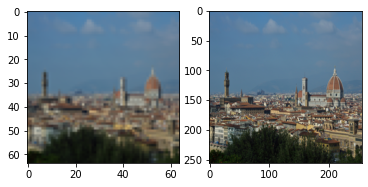

In [13]:
x, y = train_generator[0]

plt.figure()
plt.subplot(1,2,1)
plt.imshow(x)
plt.subplot(1,2,2)
plt.imshow(y)

In [14]:
train_dataset = tf.data.Dataset.from_generator(train_generator,
                                                   output_shapes=([None, None, 3], [None, None, 3]),
                                                   output_types=(x.dtype, y.dtype)).batch(batch_size)

train_dataset = train_dataset.prefetch(4)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(len(train_generator) + 1, reshuffle_each_iteration=True)

In [15]:
val_dataset = tf.data.Dataset.from_generator(val_generator,
                                                   output_shapes=([None, None, 3], [None, None, 3]),
                                                   output_types=(x.dtype, y.dtype)).batch(batch_size)
val_dataset = val_dataset.prefetch(4)
val_dataset = val_dataset.cache()

In [16]:
test_dataset = tf.data.Dataset.from_generator(test_generator,
                                                   output_shapes=([None, None, 3], [None, None, 3]),
                                                   output_types=(x.dtype, y.dtype)).batch(batch_size)
test_dataset = test_dataset.prefetch(4)
test_dataset = test_dataset.cache()

# Loss function definition

In [17]:
@tf.function
def MeanGradientError(targets, outputs):
    filter_x = tf.tile(tf.expand_dims(tf.constant([[-1, -2, -2], [0, 0, 0], [1, 2, 1]], dtype = outputs.dtype), axis = -1), [1, 1, outputs.shape[-1]])
    filter_x = tf.tile(tf.expand_dims(filter_x, axis = -1), [1, 1, 1, outputs.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = outputs.dtype), axis = -1), [1, 1, targets.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(filter_y, axis = -1), [1, 1, 1, targets.shape[-1]])

    # output gradient
    output_gradient_x = tf.math.square(tf.nn.conv2d(outputs, filter_x, strides = 1, padding = 'SAME'))
    output_gradient_y = tf.math.square(tf.nn.conv2d(outputs, filter_y, strides = 1, padding = 'SAME'))

    #target gradient
    target_gradient_x = tf.math.square(tf.nn.conv2d(targets, filter_x, strides = 1, padding = 'SAME'))
    target_gradient_y = tf.math.square(tf.nn.conv2d(targets, filter_y, strides = 1, padding = 'SAME'))

    # square
    output_gradients = tf.math.add(output_gradient_x, output_gradient_y)
    target_gradients = tf.math.add(target_gradient_x, target_gradient_y)

    # compute mean gradient error
    mge = tf.keras.metrics.mean_absolute_error(output_gradients, target_gradients)

    return mge

In [18]:
@tf.function
def overall_loss_func(y_true, y_pred):
    mae_loss = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mge_loss = MeanGradientError(y_true, y_pred)
    return mae_loss + alpha * mge_loss

# Model implementation

In [19]:
def SR_model(upscale_factor=4, channels=3):
    conv_args = {
        "activation": "relu",
        "padding": "same",
    }
    inputs = layers.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)


In [20]:
net = SR_model()
net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 48)    13872     
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 3)     0         
Total params: 74,128
Trainable params: 74,128
Non-trainable params: 0
_________________________________________________________

In [21]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=overall_loss_func, metrics=['mae', MeanGradientError])

# Training step

In [22]:
history = net.fit(
        x = train_dataset,
        epochs = epochs,
        verbose = 1,
        validation_data = val_dataset
)

Epoch 1/100
51/51 [==============================] - 11s 36ms/step - loss: 0.7134 - mae: 0.2398 - MeanGradientError: 4.7355 - val_loss: 0.5988 - val_mae: 0.1603 - val_MeanGradientError: 4.3857
Epoch 2/100
51/51 [==============================] - 1s 23ms/step - loss: 0.5324 - mae: 0.1246 - MeanGradientError: 4.0776 - val_loss: 0.4884 - val_mae: 0.0968 - val_MeanGradientError: 3.9153
Epoch 3/100
51/51 [==============================] - 1s 24ms/step - loss: 0.4727 - mae: 0.0871 - MeanGradientError: 3.8554 - val_loss: 0.4614 - val_mae: 0.0797 - val_MeanGradientError: 3.8171
Epoch 4/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4404 - mae: 0.0754 - MeanGradientError: 3.6502 - val_loss: 0.4385 - val_mae: 0.0699 - val_MeanGradientError: 3.6860
Epoch 5/100
51/51 [==============================] - 1s 23ms/step - loss: 0.4255 - mae: 0.0700 - MeanGradientError: 3.5555 - val_loss: 0.4256 - val_mae: 0.0679 - val_MeanGradientError: 3.5765
Epoch 6/100
51/51 [====================

# Visualization of training curves

dict_keys(['loss', 'mae', 'MeanGradientError', 'val_loss', 'val_mae', 'val_MeanGradientError'])


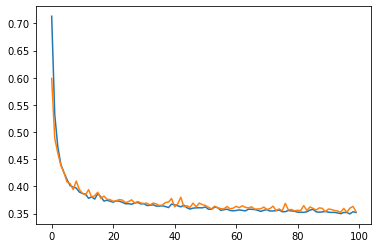

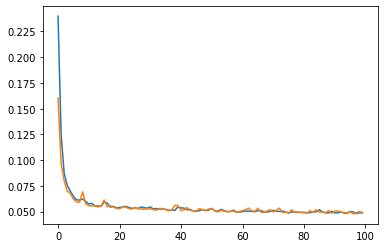

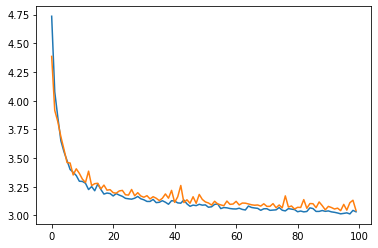

In [23]:
print(history.history.keys())
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')

plt.figure()
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')

plt.figure()
plt.plot(history.history['MeanGradientError'], label='train')
plt.plot(history.history['val_MeanGradientError'], label='val')

# Testing

In [24]:
outputs = net.predict(test_dataset)

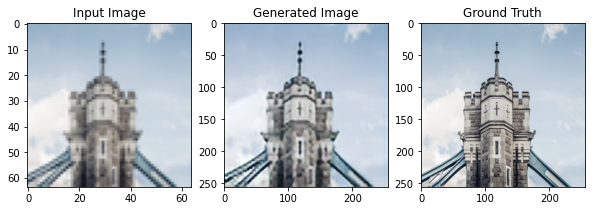

In [25]:
x, y = test_generator[3]
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(x)
plt.subplot(1,3,2)
plt.title("Generated Image")
plt.imshow(outputs[3])
plt.subplot(1,3,3)
plt.title("Ground Truth")
plt.imshow(y);

# Testing with drive images 

In [26]:
!pip install gdown

In [27]:
!gdown 17FHiPSALT3qAU8cAowSn0g-8xV09WjHl
from zipfile import ZipFile
  
! mkdir /kaggle/working/test
!mkdir /kaggle/working/output
with ZipFile("/kaggle/working/test_images_.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path="/kaggle/working/test/")

Downloading...
From: https://drive.google.com/uc?id=17FHiPSALT3qAU8cAowSn0g-8xV09WjHl
To: /kaggle/working/test_images_.zip
100%|███████████████████████████████████████| 3.26M/3.26M [00:00<00:00, 165MB/s]


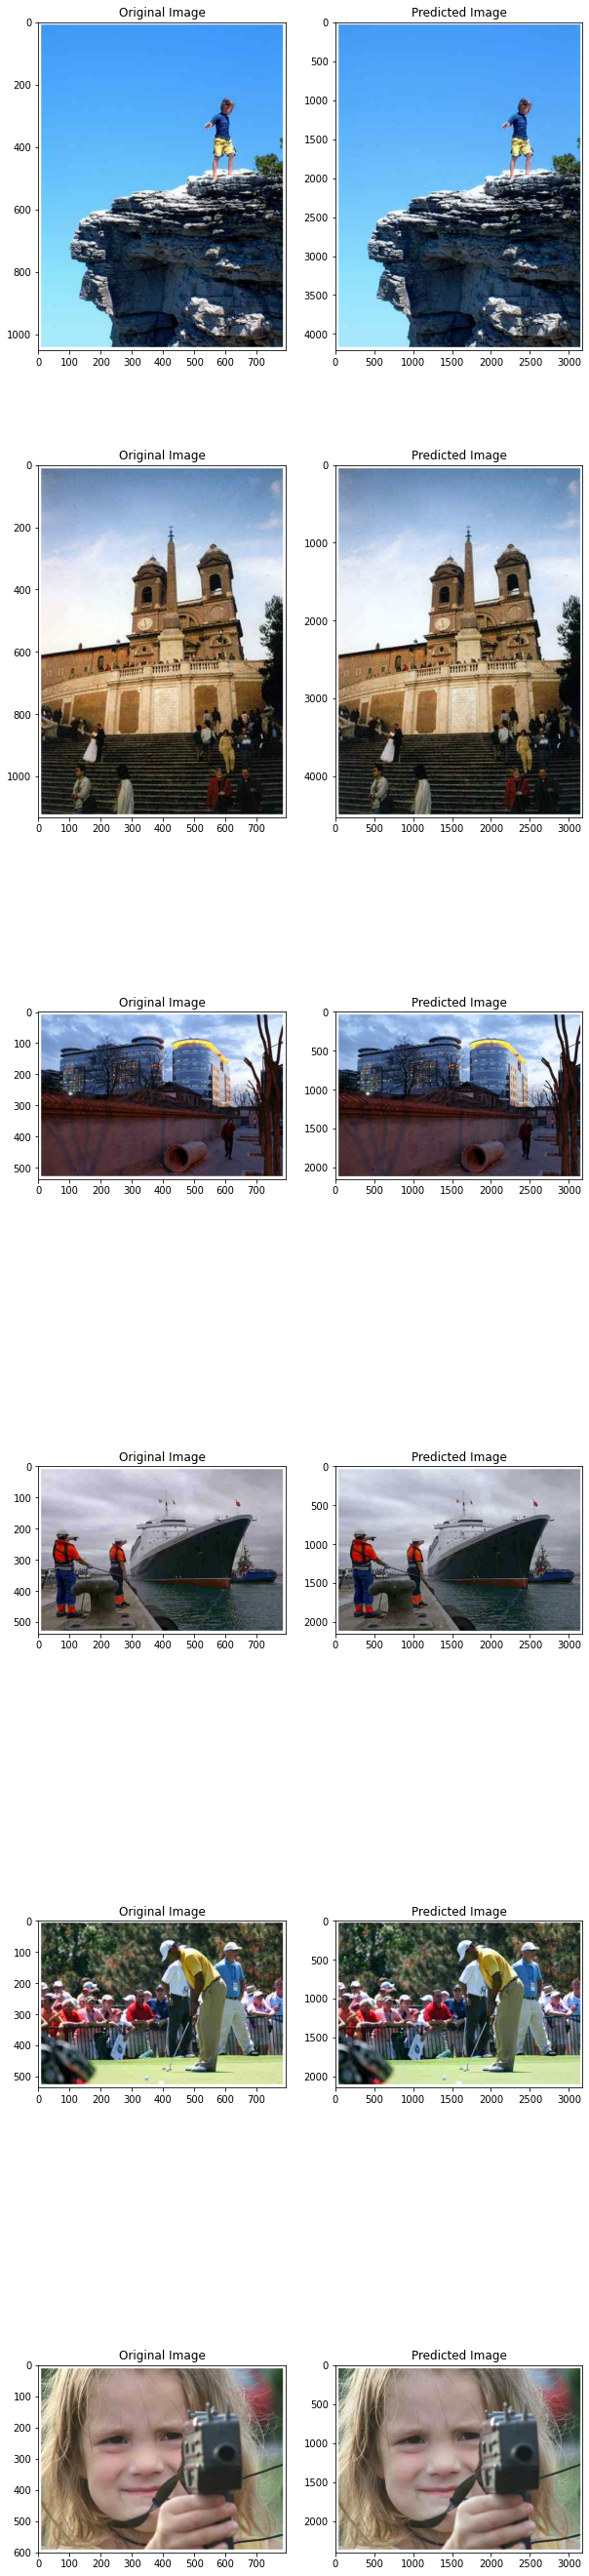

In [28]:
imgs = []
i = 1

plt.figure(figsize=(10,50))

for path in glob.glob("/kaggle/working/test/*"):
    
    plt.subplot(6,2,i)
    x = cv2.imread(path)
    plx = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    plt.imshow(plx)
    plt.title("Original Image")
    i+=1
    x = tf.keras.utils.load_img(path)
    x = tf.keras.utils.img_to_array(x)
    x = x / 255.0
    plt.subplot(6,2,i)
    pred = net.predict(tf.expand_dims(x,axis=0))
    plt.title("Predicted Image")
    plt.imshow(pred[0])
    pic = cv2.cvtColor(pred[0], cv2.COLOR_BGR2RGB)
    cv2.imwrite("/kaggle/working/output/"+path[:-4].split("/")[-1]+".png", 255*pic)
    i+=1
    

In [29]:
glob.glob("/kaggle/working/output/*")

['/kaggle/working/output/test_image_4.png',
 '/kaggle/working/output/test_image_6.png',
 '/kaggle/working/output/test_image_3.png',
 '/kaggle/working/output/test_image_2.png',
 '/kaggle/working/output/test_image_5.png',
 '/kaggle/working/output/test_image_1.png']

In [30]:
# Zipping up the output folder
!zip -r -j /kaggle/working/output.zip /kaggle/working/output

  adding: test_image_4.png (deflated 37%)
  adding: test_image_6.png (deflated 14%)
  adding: test_image_3.png (deflated 5%)
  adding: test_image_2.png (deflated 20%)
  adding: test_image_5.png (deflated 5%)
  adding: test_image_1.png (deflated 5%)
